In [2]:
!pip install torch torchvision torchaudio


  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/111.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/111.0 MB 1.9 MB/s eta 0:00:58
   ---------------------------------------- 0.1/111.0 MB 2.8 MB/s eta 0:00:40
   ---------------------------------------- 0.1/111.0 MB 2.8 MB/s eta 0:00:40
   ---------------------------------------- 0.3/111.0 MB 1.8 MB/s eta 0:01:00
   ---------------------------------------- 0.6/111.0 MB 2.5 MB/s eta 0:00:45
   ---------------------------------------- 0.7/111.0 MB 2.9 MB/s eta 0:00:39
   ---------------------------------------- 0.9/111.0 MB 2.8 MB/s eta 0:00:40
   ---------------------------------------- 1.1/111.0 MB 3.0 MB/s eta 0:00:37
   ---------------------------------------- 1.1/111.0 MB 2.9 MB/s eta 0:00:38
   ---------------------------------------- 1.2/111.0 MB 2.5 MB/s eta 0:00:45
   ---------

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import models, transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

ImportError: numpy._core.multiarray failed to import

In [3]:
train_df = pd.read_csv("../data/raw/train.csv")
test_df  = pd.read_csv("../data/raw/test.csv")

TRAIN_IMG_DIR = "../data/images/train"
TEST_IMG_DIR  = "../data/images/test"


In [4]:
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])


In [5]:
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()   # removes final classification layer
resnet = resnet.to(device)
resnet.eval()


C:\Users\91783\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\91783\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\91783/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:14<00:00, 3.32MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
def extract_image_features(df, img_dir):
    features = []
    ids = []

    missing = 0

    with torch.no_grad():
        for _, row in tqdm(df.iterrows(), total=len(df)):
            img_path = os.path.join(img_dir, f"{row['id']}.png")

            if not os.path.exists(img_path):
                missing += 1
                continue

            image = Image.open(img_path).convert("RGB")
            image = img_transform(image).unsqueeze(0).to(device)

            embedding = resnet(image)
            embedding = embedding.cpu().numpy().flatten()

            features.append(embedding)
            ids.append(row["id"])

    print(f"Skipped {missing} missing images")
    return np.array(features), ids

train_img_features, train_ids = extract_image_features(
    train_df, TRAIN_IMG_DIR
)

print(train_img_features.shape)



100%|██████████| 16209/16209 [23:28<00:00, 11.51it/s]


Skipped 2 missing images
(16207, 512)


In [8]:
test_img_features, test_ids = extract_image_features(
    test_df, TEST_IMG_DIR
)

print(test_img_features.shape)


100%|██████████| 5404/5404 [10:15<00:00,  8.77it/s]


Skipped 11 missing images
(5393, 512)


In [10]:
os.makedirs("../data/embeddings", exist_ok=True)

np.save("../data/embeddings/train_img_features.npy", train_img_features)
np.save("../data/embeddings/test_img_features.npy", test_img_features)


In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


In [12]:
# Load cleaned tabular data
train_df = pd.read_csv("../data/raw/train.csv")
test_df  = pd.read_csv("../data/raw/test.csv")

# Load image embeddings
train_img = np.load("../data/embeddings/train_img_features.npy")
test_img  = np.load("../data/embeddings/test_img_features.npy")


In [13]:
# Convert image embeddings to DataFrame
train_img_df = pd.DataFrame(train_img)
train_img_df["id"] = train_df.iloc[:len(train_img)]["id"].values

test_img_df = pd.DataFrame(test_img)
test_img_df["id"] = test_df.iloc[:len(test_img)]["id"].values


In [14]:
train_df = train_df.merge(train_img_df, on="id", how="inner")
test_df  = test_df.merge(test_img_df, on="id", how="inner")


In [15]:
tabular_features = [
    "bedrooms", "bathrooms", "sqft_living", "sqft_lot",
    "floors", "waterfront", "view", "condition", "grade",
    "sqft_above", "sqft_basement", "lat", "long",
    "sqft_living15", "sqft_lot15"
]

X_tab = train_df[tabular_features]
y = train_df["price"]


In [16]:
X_tab_train, X_tab_val, y_train, y_val = train_test_split(
    X_tab, y, test_size=0.2, random_state=42
)


In [ ]:
#Model[A] tabular only

In [20]:
scaler = StandardScaler()
X_tab_train_scaled = scaler.fit_transform(X_tab_train)
X_tab_val_scaled   = scaler.transform(X_tab_val)

lr = LinearRegression()
lr.fit(X_tab_train_scaled, y_train)

y_pred_tab = lr.predict(X_tab_val_scaled)
mse_tab = mean_squared_error(y_val, y_pred_tab)
rmse_tab = np.sqrt(mse_tab)
# rmse_tab = mean_squared_error(y_val, y_pred_tab, squared=False)
r2_tab = r2_score(y_val, y_pred_tab)

print("TABULAR ONLY RMSE:", rmse_tab)
print("TABULAR ONLY R²:", r2_tab)


TABULAR ONLY RMSE: 210823.5493851212
TABULAR ONLY R²: 0.6549418051594582


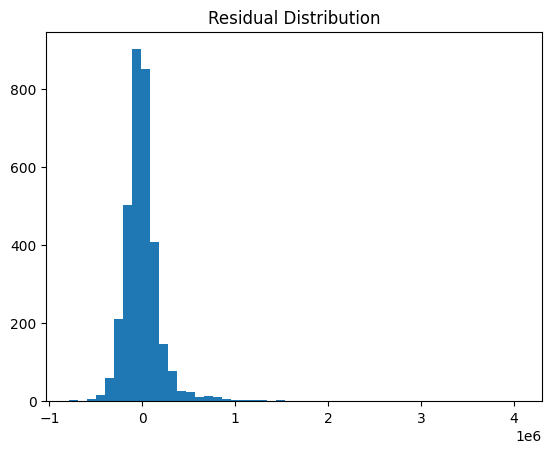

In [56]:
residuals = y_val - y_pred_tab

plt.hist(residuals, bins=50)
plt.title("Residual Distribution")
plt.show()

In [62]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_val, y_pred_tab)
print("mean absolute error(tab) : ",mae)

mean absolute error(tab) :  131294.79915305498


In [21]:
#Model [B]

In [30]:
image_features = [col for col in train_df.columns if col not in tabular_features + ["id", "price"]]

X_img = train_df[image_features].select_dtypes(include=["number"])
X_tab = train_df[tabular_features].select_dtypes(include=["number"])
X_multi = np.hstack([
    scaler.fit_transform(X_tab),
    X_img.values
])


In [31]:
print("X_tab shape:", X_tab.shape)
print("X_img shape:", X_img.shape)
print("X_img dtypes:\n", X_img.dtypes.value_counts())


X_tab shape: (16405, 15)
X_img shape: (16405, 515)
X_img dtypes:
 float32    512
int64        3
Name: count, dtype: int64


In [32]:
X_train_m, X_val_m, y_train, y_val = train_test_split(
    X_multi, y, test_size=0.2, random_state=42
)


In [33]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_m, y_train)
y_pred_multi = rf.predict(X_val_m)

# Metrics
rmse_multi = np.sqrt(mean_squared_error(y_val, y_pred_multi))
r2_multi = r2_score(y_val, y_pred_multi)

print("MULTIMODAL RMSE:", rmse_multi)
print("MULTIMODAL R²:", r2_multi)


MULTIMODAL RMSE: 149150.00033741395
MULTIMODAL R²: 0.8272967056745666


In [37]:
from sklearn.model_selection import cross_val_score
rf = RandomForestRegressor(
    n_estimators=150,   # slightly lower
    max_depth=18,
    random_state=42,
    n_jobs=-1
)

scores = cross_val_score(
    rf, X_multi, y,
    cv=2,
    scoring="r2"
    
)

print("CV R² scores:", scores)
print("Mean CV R²:", scores.mean())


exception calling callback for <Future at 0x1f5717f2990 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "C:\Users\91783\anaconda3\Lib\site-packages\joblib\externals\loky\_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "C:\Users\91783\anaconda3\Lib\site-packages\joblib\parallel.py", line 385, in __call__
    "temp_folder": temp_folder,
        ^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\site-packages\joblib\parallel.py", line 834, in dispatch_next
  File "C:\Users\91783\anaconda3\Lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    # in the order of completion instead of submission.
        ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    # call just before being aborted by the reset.
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\site-packages\joblib\_parallel_backends.py", lin

ValueError: 
All the 2 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\91783\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    end_msg = f"[CV{progress_msg}] END "
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "C:\Users\91783\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 487, in fit
    n_jobs=self.n_jobs,
        ^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 77, in __call__
    # https://docs.python.org/3.14/whatsnew/3.14.html#concurrent-safe-warnings-control
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\site-packages\joblib\parallel.py", line 1098, in __call__
    constructing list of arguments.
              ^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\site-packages\joblib\parallel.py", line 975, in retrieve
    oversubscription. In some cases, slight oversubscription can be
                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\site-packages\joblib\_parallel_backends.py", line 567, in wrap_future_result
    " below threads, setting n_jobs=1",
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\concurrent\futures\_base.py", line 456, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\concurrent\futures\_base.py", line 401, in __get_result
    raise self._exception
joblib.externals.loky.process_executor.TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\91783\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    end_msg = f"[CV{progress_msg}] END "
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
  File "C:\Users\91783\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 487, in fit
    n_jobs=self.n_jobs,
        ^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 77, in __call__
    # https://docs.python.org/3.14/whatsnew/3.14.html#concurrent-safe-warnings-control
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\site-packages\joblib\parallel.py", line 1098, in __call__
    constructing list of arguments.
              ^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\site-packages\joblib\parallel.py", line 975, in retrieve
    oversubscription. In some cases, slight oversubscription can be
                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\site-packages\joblib\_parallel_backends.py", line 567, in wrap_future_result
    " below threads, setting n_jobs=1",
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\concurrent\futures\_base.py", line 456, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\concurrent\futures\_base.py", line 401, in __get_result
    raise self._exception
  File "C:\Users\91783\anaconda3\Lib\site-packages\joblib\externals\loky\_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "C:\Users\91783\anaconda3\Lib\site-packages\joblib\parallel.py", line 385, in __call__
    "temp_folder": temp_folder,
        ^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\site-packages\joblib\parallel.py", line 834, in dispatch_next
  File "C:\Users\91783\anaconda3\Lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    # in the order of completion instead of submission.
        ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    # call just before being aborted by the reset.
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\site-packages\joblib\_parallel_backends.py", line 556, in apply_async
    "Multiprocessing-backed parallel loops cannot be nested,"
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\site-packages\joblib\externals\loky\reusable_executor.py", line 176, in submit
    is_reused = False
       ^^^^^^^^^^^^^^^
  File "C:\Users\91783\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py", line 1129, in submit
joblib.externals.loky.process_executor.TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.



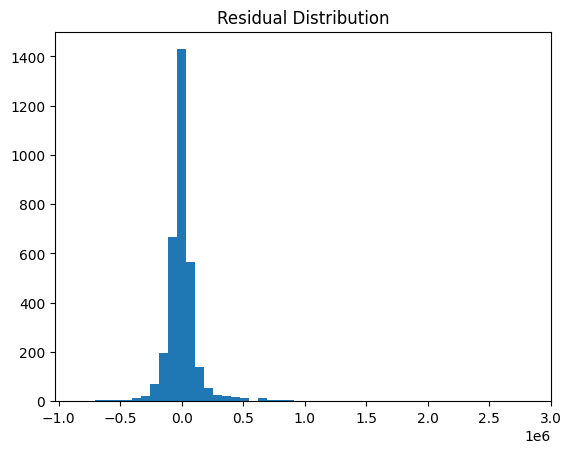

In [55]:
residuals = y_val - y_pred_multi

plt.hist(residuals, bins=50)
plt.title("Residual Distribution")
plt.show()

In [60]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_val, y_pred_multi)
print("mean absolute error(multi) : ",mae)

mean absolute error(multi) :  79860.23227923262


In [38]:
## Phase 6: Explainability with Grad-CAM


In [40]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from PIL import Image


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet18(pretrained=True)
resnet = resnet.to(device)
resnet.eval()


C:\Users\91783\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\91783\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [42]:
target_layer = resnet.layer4[-1]


In [50]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor):
        output = self.model(input_tensor)
        score = output.mean()  # regression proxy
        self.model.zero_grad()
        score.backward()

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam.squeeze().detach().cpu().numpy()


In [51]:
from torchvision import transforms

img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

def load_image(path):
    img = Image.open(path).convert("RGB")
    tensor = img_transform(img).unsqueeze(0).to(device)
    return img, tensor


In [52]:
gradcam = GradCAM(resnet, target_layer)

# Pick ANY image (prefer expensive & cheap examples)
sample_id = train_df.sample(1)["id"].values[0]
img_path = f"../data/images/train/{sample_id}.png"

original_img, input_tensor = load_image(img_path)
cam = gradcam.generate(input_tensor)


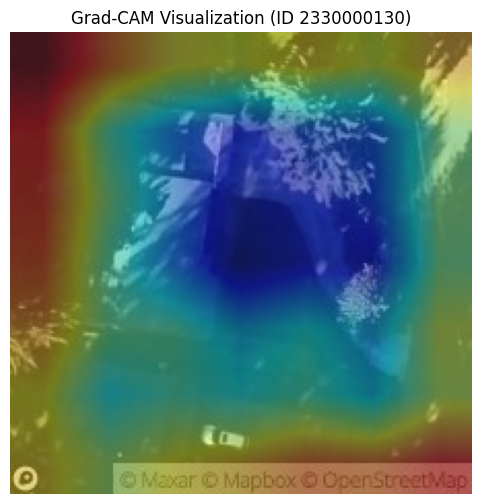

In [53]:
def overlay_cam(img, cam):
    img = np.array(img)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    return overlay

overlay = overlay_cam(original_img, cam)

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.axis("off")
plt.title(f"Grad-CAM Visualization (ID {sample_id})")
plt.show()
